# Random Forest

## Data Preprocessing

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

# Set working directory
month_file = '4_August'
# Set working directory
os.chdir("/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month/"+month_file+"/Ending Balances/Per_Player")

In [3]:
# Filter Columns
filter = ['session_time', 'gender', 'age_gen', 'day', 'timeofday', 'first_outcome',
        'first_wager','first_p/b', 'last_outcome', 'last_wager', 'last_p/b',
        'beginning_amt', 'ending_amt', 'ending_balance', 'ave_slotdenom', 
        'std_slotdenom', 'min_slotdenom', 'max_slotdenom', 'ave_theo_payback',
        'min_theo_payback', 'max_theo_payback', 'ave_wageramt', 'std_wageramt',
        'min_wager', 'max_wager', 'ave_p/b', 'std_p/b', 'max_p/b', 'max_profit', 'depletion_slope', 
        '#inc_slotdenom', '#dec_slotdenom', '#inc_maxbet', '#dec_maxbet',
        'w/min', 'l/min', 'nh/min', 'd/min', '2ws_profit', '2ws_wgramt','2ws/min', 
        '3ws_profit', '3ws_wgramt', '3ws/min', '4ws_profit', '4ws_wgramt', '4ws/min', 
        'w/g', 'l/g', 'nh/g', 'd/g', 'ave_time_per_gamble',
        'min_time_per_gamble', 'machines_changes', 'unique_machines', 'classification']

# Load dataset
dataset = pd.read_parquet('top_vs_ntop_player_ending_balance_by_session.parquet', columns=filter)

# Keep only session_time 1
dataset = dataset[dataset['session_time'] == 1]
# Drop age_range and playerkey
dataset = dataset.drop(['session_time'], axis=1)

## Load Dataframes

In [4]:
# Convert 'ave_time_per_machine' to seconds

# # Seperate dependent and independent variables
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Econde gender column (Binary)
le = LabelEncoder()

# Binary Encode gender and simplay
X[:, 0] = le.fit_transform(X[:, 0])

# # Encode age_generartion, day, time of day,  and time of day columns, first_outcome, and last_outcome.
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3, 4, 7])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 1)

sc = StandardScaler()

# Scale all columns except the encoded ones
X_train[:, 25:] = sc.fit_transform(X_train[:, 25:])
X_test[:, 25:] = sc.transform(X_test[:, 25:])

## Handling Class Imbalance 
# Apply SMOTE - SMOTE generates synthetic samples for the minority class to balance the dataset:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train_resampled, y_train_resampled)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro', zero_division=1))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print('F1 Score: ', f1_score(y_test, y_pred, average='macro'))

[[2022  108]
 [ 128  142]]
Accuracy:  0.9016666666666666
Precision:  0.7542325581395348
Recall:  0.7376108502869065
F1 Score:  0.7455068296189792


## Cumulative Accuracy Profile (CAP) Graph

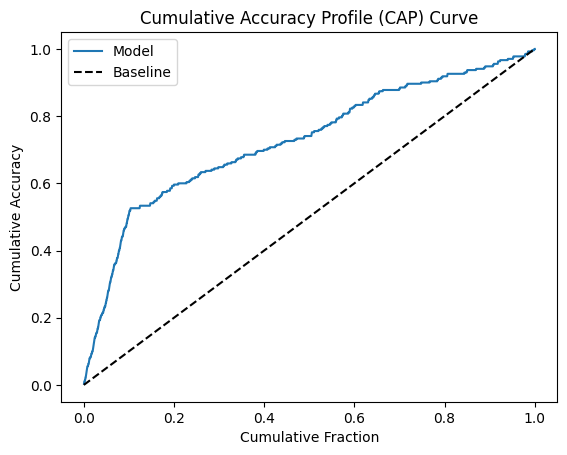

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the predicted probabilities or scores named 'predicted_scores' and true labels named 'true_labels'

# Sort the scores and corresponding true labels
sorted_indices = np.argsort(y_pred)[::-1]
sorted_true_labels = y_test[sorted_indices]

# Calculate cumulative metrics
total_positive = np.sum(y_test)
cumulative_positives = np.cumsum(sorted_true_labels)
cumulative_accuracy = cumulative_positives / total_positive
cumulative_fraction = np.arange(1, len(sorted_true_labels) + 1) / len(sorted_true_labels)

# Create the CAP curve plot
plt.plot(cumulative_fraction, cumulative_accuracy, label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('Cumulative Fraction')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy Profile (CAP) Curve')
plt.legend()
plt.show()

## Hyperparameter Tuning

In [6]:
# Define the hyperparameters and their respective ranges
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the data to perform the search
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro', zero_division=1))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1 Score:', f1_score(y_test, y_pred, average='macro'))

# Print the best hyperparameters
print('Best Hyperparameters:', best_params)

Confusion Matrix:
[[2011  119]
 [ 119  151]]
Accuracy: 0.9008333333333334
Precision: 0.7516953573291602
Recall: 0.7516953573291602
F1 Score: 0.7516953573291602
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


## Cross Validation

In [7]:
from sklearn.model_selection import StratifiedKFold

# dataset['ave_time_per_machine'] = dataset['ave_time_per_machine'].dt.total_seconds()

# Seperate dependent and independent variables
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Encode gender column (Binary)
le = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])

# Encode other categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3, 4, 7])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

y = le.fit_transform(y)

# Initialize stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)


# Lists to store evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale all columns except the encoded ones
    X_train[:, 25:] = sc.fit_transform(X_train[:, 25:])
    X_test[:, 25:] = sc.transform(X_test[:, 25:])

    # Apply SMOTE to balance the dataset
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    # Train the classifier
    classifier = RandomForestClassifier(random_state=0, **best_params)
    classifier.fit(X_train_resampled, y_train_resampled)

    # Predict on the test set
    y_pred = classifier.predict(X_test)

    # Calculate evaluation metrics for this fold
    cm = confusion_matrix(y_test, y_pred)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred, average='macro', zero_division=1))
    recall_scores.append(recall_score(y_test, y_pred, average='macro'))
    f1_scores.append(f1_score(y_test, y_pred, average='macro'))

# Print the average evaluation metrics over all folds
print('Average Accuracy: ', np.mean(accuracy_scores))
print('Average Precision: ', np.mean(precision_scores))
print('Average Recall: ', np.mean(recall_scores))
print('Average F1 Score: ', np.mean(f1_scores))

Average Accuracy:  0.9161666666666667
Average Precision:  0.7812907845471726
Average Recall:  0.7920172464685805
Average F1 Score:  0.7863325414569343


In [8]:
results = ['RF', np.mean(accuracy_scores), np.std(accuracy_scores), np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores)]
columns = ['Model', 'Mean Accuracy', 'Std of Accuracy', 'Precision', 'Recall', 'F1 Score']
results_df = pd.DataFrame([results], columns=columns)

# Print the results as a LaTeX table
latex_table = results_df.to_latex(index=False, escape=False)
print(latex_table)

\begin{tabular}{lrrrrr}
\toprule
Model &  Mean Accuracy &  Std of Accuracy &  Precision &   Recall &  F1 Score \\
\midrule
   RF &       0.916167 &         0.005907 &   0.781291 & 0.792017 &  0.786333 \\
\bottomrule
\end{tabular}



/var/folders/vp/1skwx2kd29s4fxnxx7tt9r6w0000gn/T/ipykernel_31540/3337804797.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = results_df.to_latex(index=False, escape=False)


## Feature Importance

In [9]:
from sklearn.inspection import permutation_importance

# drop last column
dataset= dataset.drop(['classification'], axis=1)


result = permutation_importance(classifier, X_test, y_test, n_repeats=10, random_state=42)

# Extract feature coefficients (importance)
feature_importance = result.importances_mean

# Modify the get_feature_names_out function to exclude 'remainder__'
def get_feature_names_without_prefix(transformer, input_features=None):
    return [f.split('remainder__')[-1] for f in transformer.get_feature_names_out(input_features)]

# Get the feature names without 'remainder__' prefix
feature_names = get_feature_names_without_prefix(ct, input_features=dataset.columns)
coefs_with_names = list(zip(feature_names, feature_importance))

# Sort coefficients by magnitude (absolute value) in descending order
coefs_with_names.sort(key=lambda x: abs(x[1]), reverse=True)

# Turn the coefficients into a DataFrame
df = pd.DataFrame(coefs_with_names, columns=['feature', 'coefficient'])

# Print the top 10 features
print(df.head(10))

               feature  coefficient
0              max_p/b     0.007833
1           2ws_profit     0.007333
2  min_time_per_gamble    -0.006417
3      unique_machines    -0.004917
4           3ws_wgramt    -0.004667
5              3ws/min     0.004417
6     machines_changes    -0.003833
7              std_p/b    -0.003417
8  ave_time_per_gamble     0.003333
9           2ws_wgramt     0.003083
